In [1]:
!pip install numpy
!pip install opencv-python
!pip install matplotlib
!pip install scikit-image
!pip install tqdm
!pip install fingerprint

In [4]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import distance

def preprocess_image(image_path, kernel):
    img = cv2.imread(image_path, 0)
    if img is None:
        raise ValueError(f"Image at {image_path} could not be loaded")
    
    rows, cols = img.shape[:2]
    img_filtered = np.zeros(img.shape, dtype=np.uint8)
    ks = kernel.shape[0]

    for i in range(1, rows-1):
        for j in range(1, cols-1):
            result = 0
            for k_i in range(0, ks):
                for k_j in range(0, ks):
                    result += img[i-ks//2+k_i, j-ks//2+k_j] * kernel[(ks-1)-k_i, (ks-1)-k_j]  # convolution
            result = np.clip(result, 0, 255)  # 값을 0과 255 사이로 클리핑
            img_filtered[i, j] = int(result)
    
    _, img_bin = cv2.threshold(img_filtered, 127, 255, cv2.THRESH_BINARY_INV)
    
    return img_bin

def detect_minutiae(img):
    rows, cols = img.shape
    minutiae_end = []
    minutiae_bif = []
    
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            if img[i, j] == 255:
                window = img[i-1:i+2, j-1:j+2]
                white_pixels = np.sum(window) // 255
                
                if white_pixels == 2:  # Ending point
                    minutiae_end.append((i, j))
                elif white_pixels == 4:  # Bifurcation point
                    minutiae_bif.append((i, j))
                    
    return minutiae_end, minutiae_bif

# 필터 설정
kernel = np.array((
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
))

# 특정 test2 파일들에 대해 Minutiae 추출
testset_files = ['46_type2.bmp', '82_type1.bmp', '120_type1.bmp']
testset_dir = './Downloads/test2/test2'

testset_minutiae = {}
for image_file in tqdm(testset_files, desc='Processing testset'):
    img_path = os.path.join(testset_dir, image_file)
    img_bin = preprocess_image(img_path, kernel)
    end_points, bif_points = detect_minutiae(img_bin)
    testset_minutiae[image_file] = {'end_points': end_points, 'bif_points': bif_points}

# 특정 train 파일들에 대해 Minutiae 추출
train_files = ['1.bmp', '5.bmp', '3.bmp']
trainset_dir = './Downloads/train/train_ref'

trainset_minutiae = {}
for image_file in tqdm(train_files, desc='Processing trainset'):
    img_path = os.path.join(trainset_dir, image_file)
    img_bin = preprocess_image(img_path, kernel)
    end_points, bif_points = detect_minutiae(img_bin)
    trainset_minutiae[image_file] = {'end_points': end_points, 'bif_points': bif_points}


Processing trainset: 100%|███████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.25s/it]


In [5]:
def match_minutiae(test_minutiae, train_minutiae, threshold=15):
    match_count = 0
    
    for test_point in test_minutiae:
        for train_point in train_minutiae:
            if distance.euclidean(test_point, train_point) < threshold:
                match_count += 1
                break
                
    return match_count

def calculate_metrics(matches, total_test, total_train):
    precision = matches / total_test if total_test else 0
    recall = matches / total_train if total_train else 0
    frr = 1 - recall
    far = 1 - precision
    accuracy = (matches * 2) / (total_test + total_train) if (total_test + total_train) else 0
    
    return precision, recall, far, frr, accuracy

# 매칭 및 성능 평가
threshold = 15  # 설정한 threshold 값
metrics = []

for test_file in tqdm(testset_minutiae, desc='Matching testset'):
    test_data = testset_minutiae[test_file]
    best_match = None
    best_match_count = 0
    
    for train_file in trainset_minutiae:
        train_data = trainset_minutiae[train_file]
        match_count_end = match_minutiae(test_data['end_points'], train_data['end_points'], threshold)
        match_count_bif = match_minutiae(test_data['bif_points'], train_data['bif_points'], threshold)
        total_match_count = match_count_end + match_count_bif
        
        if total_match_count > best_match_count:
            best_match_count = total_match_count
            best_match = train_file
            
    precision, recall, far, frr, accuracy = calculate_metrics(
        best_match_count,
        len(test_data['end_points']) + len(test_data['bif_points']),
        len(trainset_minutiae[best_match]['end_points']) + len(trainset_minutiae[best_match]['bif_points'])
    )
    
    metrics.append({
        'test_file': test_file,
        'best_match': best_match,
        'precision': precision,
        'recall': recall,
        'far': far,
        'frr': frr,
        'accuracy': accuracy
    })

# 결과 출력
for metric in metrics:
    print(f"Test File: {metric['test_file']}")
    print(f"Best Match: {metric['best_match']}")
    print(f"Precision: {metric['precision']:.2f}")
    print(f"Recall: {metric['recall']:.2f}")
    print(f"FAR: {metric['far']:.2f}")
    print(f"FRR: {metric['frr']:.2f}")
    print(f"Accuracy: {metric['accuracy']:.2f}")
    print()


Matching testset: 100%|██████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.80it/s]

Test File: 46_type2.bmp
Best Match: 5.bmp
Precision: 0.82
Recall: 1.02
FAR: 0.18
FRR: -0.02
Accuracy: 0.91

Test File: 82_type1.bmp
Best Match: 5.bmp
Precision: 0.87
Recall: 0.84
FAR: 0.13
FRR: 0.16
Accuracy: 0.86

Test File: 120_type1.bmp
Best Match: 1.bmp
Precision: 0.96
Recall: 0.22
FAR: 0.04
FRR: 0.78
Accuracy: 0.35



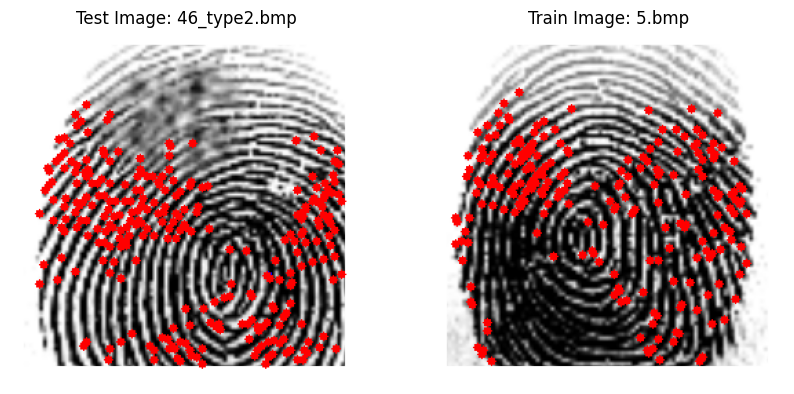

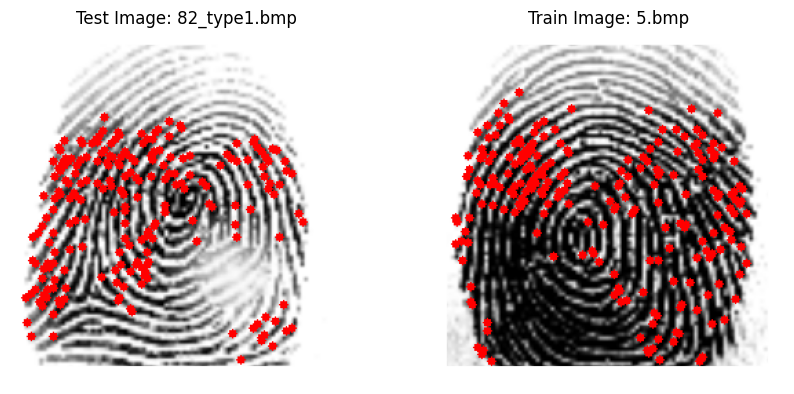

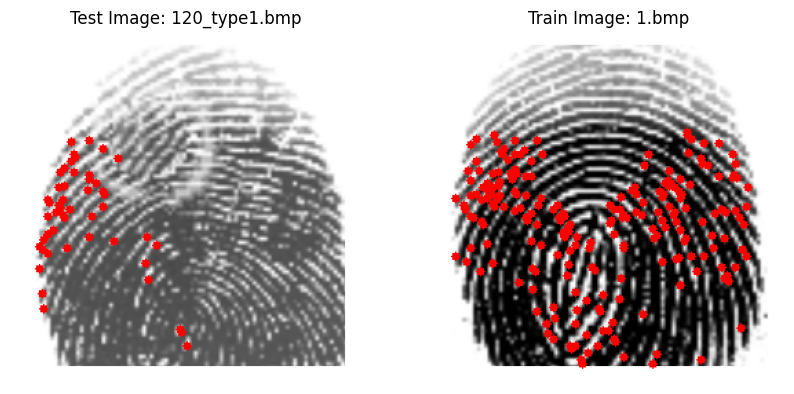

In [13]:
# 매칭된 지점을 연결하여 강조한 이미지 생성
for metric in metrics:
    test_img_path = os.path.join(testset_dir, metric['test_file'])
    train_img_path = os.path.join(trainset_dir, metric['best_match'])
    
    test_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
    train_img = cv2.imread(train_img_path, cv2.IMREAD_GRAYSCALE)
    
    test_data = testset_minutiae[metric['test_file']]
    train_data = trainset_minutiae[metric['best_match']]
    
    test_img_with_minutiae = draw_minutiae(test_img, test_data['end_points'], test_data['bif_points'])
    train_img_with_minutiae = draw_minutiae(train_img, train_data['end_points'], train_data['bif_points'])
    
    # 각 test 끝점을 가장 가까운 train 끝점에 연결하는 선 그리기
    for test_end_point in test_data['end_points']:
        min_distance = float('inf')
        closest_train_end_point = None
        
        for train_end_point in train_data['end_points']:
            distance = np.linalg.norm(np.array(test_end_point) - np.array(train_end_point))
            if distance < min_distance:
                min_distance = distance
                closest_train_end_point = train_end_point
        
        if closest_train_end_point is not None:
            cv2.line(test_img_with_minutiae, (test_end_point[1], test_end_point[0]), (closest_train_end_point[1], closest_train_end_point[0]), (0, 255, 0), 1)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(test_img_with_minutiae, cmap='gray')
    plt.title(f"Test Image: {metric['test_file']}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(train_img_with_minutiae, cmap='gray')
    plt.title(f"Train Image: {metric['best_match']}")
    plt.axis('off')
    
    plt.show()
